# Fast isochrone fitting of stellar parameters, in particular ages,   <br>  constrained by spectropic labels, photometry and distance

<br>
(Version 7, Sep 1, 2023; HWR)

<br>
<br>

<font size="3">
This notebook, triggered by Gaia DR3 data in the Galactic disk and in the LMC, aims to determine  stellar parameters via 'isochrone fitting' -- in particular stellar masses and ages -- for large ensembles stars for which we have stellar labels (esp. T$_{eff}$, log$g$, and [M/H]) along with photometry in a number of bands (here, BP, G, RP, J, H and K), and an estimate of the distance. It presumes these quantities and their uncertainties are known. In the current version, it presumes no external knowledge of the extinction (A$_G$), which it also determines.
<br>
In an effort to make the code fast -- so that $10^6$ objects can be done on a laptop -- the code avoids any isochrone interpolation. The basic logical flow of the code is as follows:
    
+ ingest an extensive grid of isochrones (here Parsec isochriones), that is presumed to be densely sampled enough in [M/H] and logAge. "Densely enough" here means simply being more finely sampled than the final uncertainties in the estimate. It also assumes implicitly that each isochrone -- which is a sequence of points in initial stellar mass M$_{init}$ (e.g. Parsec) or effective evolutionary state, EES (e.g. MIST) -- is finely enough sampled in M$_{init}$. Here, finely enough' is a tricky issue, as it also means the 'observable' (T$_{eff}$ ir photometry) don't change too much. By construction, good isochrone grids come close, in the evolutionary phases that matter.
Here, we use M$_{init}$ and Parsec.
    
+ then create copies of this isochrone grid that are -- in their photometric predictions -- reddened by a (sufficient) set of A$_G$'s. So that we are left with a (yes, large) grid in 4D space: [M/H], logAge, A$_G$ and 
M$_{init}$. This grid is one part of an Table, with the other part being the "observational predictions" for each of these grid points. Here: T$_{eff}$, log$g$, [M/H]) BP, G, RP, J, H and K.
    
+ the basic "fitting approach" for any given data point is sketched here (ADD LINK). It is a proper Bayesian estimate of the stellar parameters' posterior, described by the mean values of [M/H], logAge, A$_G$ and 
M$_{init}$ and their uncertainties (also the full covariance matrix). The "trick" to make this fast is to effect all this by a weighted sum over the pertinent subset of the isochrone points. This brings up two issues:
    
    * quickly find the subset of (also) reddened isochrone points, where the data likelihood is not vanishing. Here this is done by boolean selection conditions to get only isochrone points within $7\sigma$ of the observed T$_{eff}$, G and K; more conditions could be added (e.g. $A_G$), which would speed up the code.
    
    * then, the posterior parameter estimates and their uncertainties are calculated as a weighted some over the pre-selected isochrone points.  There are three kinds of weights that come in:
        * the $\exp\bigl ( - \chi^2(\mathrm{data, uncertainties, model\  predictions})\bigr )$
        * the isochrone point weight, which accounts for the fact that rapid evolutionary phases are finely sampled in isochroned. Within an isochrone, we sum over isochrone points (instead of over M$_{init}$) we need the Jacobian $d M_{init}/dN_{isochrones}$. This "penalizes"  isochrone points that are shortlived.
        * while we take priors in [M/H] and logAge to be flat, we account for the (Kroupa-esque) mass function, via $p_{Kroupa}(M_{init}$). 
    
In the version of Sep 3, 2023 this takes about 90 mili-seconds / object on HWRs notebook.

</font>

### settled and open issues  (of this version v7, Sep 1, 2023)


* we need to understand which pieces of the data "dominate" the fit, the G-band magnitudes?  The path forward here is to look at the difference between the "data" and the "best fit isochrones". E.g. the metallicities often get shifted around a lot. I.e. there is systematic "tension" between the model predictions and the data

* do we need to re-weigh spectroscopy and photometry? Currently, I have implemented an 0.03mag floor on the photometric error.

* in the current application , a simple distance to the LMC (DM=18.48) is assumed.

* do we need to consider a finer grid of extinctions and of (young) ages?

* in the end, only data points with spectroscopic labels $3500 K < T_{eff} < 4900 K$ are trustworthy

* NOTE: I put some double checking notes in the function call that filters out the right isochrones...


### next steps

* can we identify members of known clusters for age calibration

* identify points that have unusual D$\chi^2$ weights, and understand why they got selected. This may require getting the a set of chi2s returned, all that are within XXX of the minimum.

* understand whether we should create a much finer grid of extinctions, but only select the ones where the observed colors are consistent with Teff and th eexpected reddening range.



set up packages ...

In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import time
import timeit


from astropy.io import fits as fits

from astropy.table import Table,vstack, hstack,Column
from astropy.io import ascii
from astropy.io.votable import parse_single_table


from matplotlib.colors import LogNorm
import scipy.stats as stats

import astropy.table as at
from astropy.coordinates import SkyCoord
from astropy import units as u

from pyia import GaiaData

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sys

from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

#### read in pre-downloaded isochrones; this version uses the Parsec grid from Josh Povick, subsampled in both [M/H] and at (older) ages; but augmented at young ages.

#### set the right work directory

In [2]:
workdir = '/Users/rix/Science/Projects/GAIA/GaiaDR3/BP-RP/LMC/'

In [3]:
# from povick
# isochrone = 'parsec36_Povick_sparsed.fits'     # obsolete now
isochrone = 'parsec36_Povick_sparsed_young_added.fits'
iso = at.Table.read(workdir+isochrone)


In [4]:
### it annoys HWR, so logT --> Teff
# ... i.e. switch to linear temperatures
iso['logTe'] = 10.** iso['logTe'] 
iso.rename_column('logTe', 'Teff')

The table reflecting the input isochrone grid has 704283  rows at present, with the following coverage: 


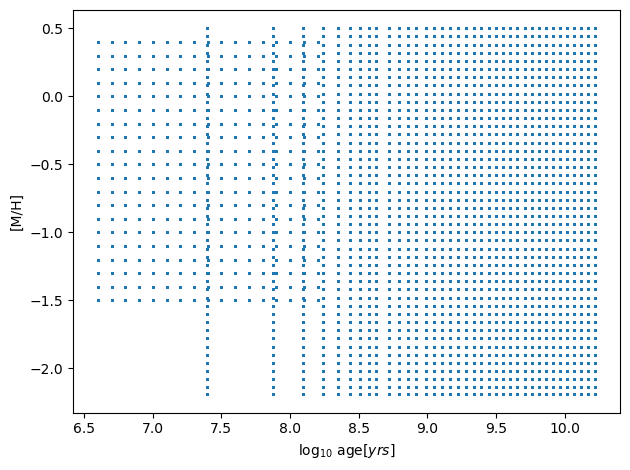

In [5]:
print('The table reflecting the input isochrone grid has',len(iso),' rows at present, with the following coverage: ')
plt.scatter(iso['logAge'],iso['MH'],s=1)
plt.xlabel('$\log_{10} ~\mathrm{age} [yrs]$')
plt.ylabel('[M/H]')
plt.show()

### What's in the table?

In [6]:
print('The isochrone table has the following columns: ',iso.columns)
#and how many rows does it have
print(' there are a total of ',len(iso),' rows')
#print('the data types are',iso[:].dtype)

The isochrone table has the following columns:  <TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','Teff','logg','label','McoreTP','Jmag','Hmag','Ksmag','Gmag','G_BPmag','G_RPmag')>
 there are a total of  704283  rows


In [7]:
# just a visual check
print(iso[3])

   Zini    MH   logAge      Mini         int_IMF        Mass  logL        Teff         logg label McoreTP  Jmag Hmag       Ksmag        Gmag  G_BPmag G_RPmag
--------- ---- -------- ----------- ------------------ ----- ----- ------------------ ----- ----- ------- ----- ---- ----------------- ------ ------- -------
0.0060543 -0.4 10.17173 0.136330694 1.4183171987999998 0.136 -2.72 2989.5099278145867 5.146     1     0.0 9.551 9.01 8.767000000000001 12.748  14.637   11.46


###   We now calculate the "weights" (or probability) of each isochrone point
* we presume that the probability is uniforem with respect to (logAge) and MH
* we will implement the IMF probability, presuming a kroupa IMF
* the most important part is the $\frac{dM_{init}}{d{\mathrm \ grid\  point}}$, which is calculated in the step below
* in the end we will add $-2\times ln(p_{grid})$ to the $\chi^2$ of each grid point, given a data point

##### first auxiliary step: define a Kroupa normalized MF

In [8]:
def kroupa_imf(m, m_min=0.01, m_max=100, m1=0.08, m2=0.5, alpha1=0.3,alpha2=1.3,alpha3=2.3):
    
    # Calculate normalization constants for each segment to ensure continuity
    A1 = (alpha2 - alpha1) / (m1**(alpha2 - alpha1) - m_min**(alpha2 - alpha1))
    A2 = A1 * m1**(alpha2 - alpha1)
    A3 = A2 * m2**(alpha3 - alpha2)
    
    # Calculate the contributions to the normalization factor from each segment
    norm1 = A1 / (1 - alpha1) * (m1**(1 - alpha1) - m_min**(1 - alpha1))
    norm2 = A2 / (1 - alpha2) * (m2**(1 - alpha2) - m1**(1 - alpha2))
    norm3 = A3 / (1 - alpha3) * (m_max**(1 - alpha3) - m2**(1 - alpha3))
    
    # Calculate the total normalization factor
    norm_factor = norm1 + norm2 + norm3
    
    # Define the IMF
    if m < m1:
        return A1 * m**(-alpha1) / norm_factor
    elif m1 <= m < m2:
        return A2 * m**(-alpha2) / norm_factor
    else:
        return A3 * m**(-alpha3) / norm_factor

#### Now, take add the two components of the weighting, the intrinsic speed of the isochrone evolution at that point, and the IMF probability of having a star at that mass. This will simply become a value-added column in the overall isochrone table.

* The intrinsic speed of the isochrone evolution at any point is simply quantified as the $d M_{init}/dN_{isochrones}$, which will end up in a new table column, iso\['DMini'\]

* We express both the isochrone point weight and the IMF weight via a $\chi^2$ equivalent

In [9]:
# first calculate the probability of mass "Mini" given a Kroupa IMF
kroupa_probability = [kroupa_imf(m) for m in iso['Mini']]

# Create a new column 'DMini' filled with zeros initially
iso['DMini'] = 1.e-14

# Loop through the rows of the table from the second row to the second-last row
for i in range(1, len(iso) - 1):
    if iso['Mini'][i + 1] > iso['Mini'][i] and iso['Mini'][i - 1] < iso['Mini'][i]:
        iso['DMini'][i] = 0.5 * (iso['Mini'][i + 1] - iso['Mini'][i - 1])
    else:
        iso['DMini'][i] = 1.e-14
        
# this is a crucial step. It calculates the prior probability of each isochrone point
iso['Dchi2_corr'] = -2*np.log(iso['DMini']) - 2*np.log(kroupa_probability)

#print(iso['Dchi2_corr'])

### Create dust-reddened versions of the isochrone predictions

##### Why?
In the end, we want to find the isochrone points that best fit the data, both the spectroscopic parameters and the photometry. For a given set of spectroscopic parameters, the reddening changes the photometry

##### Why so early in the code?

-- we have to do it only once

-- we want to index the final rows of the isochrone table at the start for 

#### What needs to be done?

1) We define the reddening vector RV (Cardelli) and an array of Av values (see in cell).

2) We add a zero-Av column to the original table iso.

3) We initialize an empty list all_tables to store the original and modified tables.

4) A for-loop iterates over each Av value. Inside the loop, we create a modified version of iso_pred by adding Av * RV to the columns 'G_BPmag','Gmag','G_RPmag','Jmag','Hmag','Ksmag'.
####!!! the column names are hardwired at the moment !!!

5) We add a new 'Av' column to the modified table with the applied Av value.

6) Finally, we vertically stack all the tables together to create iso_pred_ext, which contains the original and modified versions of iso_pred.

In [10]:
# these are RV valies for BP,G,RP,J,H,K from Cardelli (via Povick)
RV = np.array([1.21821835, 1., 0.77005965, 0.34260963, 0.21702019, 0.13758333])
# this sets the reddening grid, and needs to be re-considered
Av = np.array([0., 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.2, 1.6, 2.1])
## temp for the large table
#Av = np.array([0., 0.06, 0.1, 0.15, 0.2,  0.3,  0.5, 0.9])

# Add a zero-Av column to the original table
iso['Av'] = np.zeros(len(iso))

# Initialize list to store modified tables
all_tables = [iso]

# Loop over each Av value to create modified tables
for av in Av[1:]:  # Skip the first value (0) as the original table already covers it
    mod_table = iso.copy()  # Make a copy of the original table
    ### column names hardwired here !!!
    for i, col_name in enumerate(['G_BPmag','Gmag','G_RPmag','Jmag','Hmag','Ksmag']):
        mod_table[col_name] += av * RV[i]  # Apply the reddening
    mod_table['Av'] = np.full(len(mod_table), av)  # Fill the 'Av' column with the current Av value
    all_tables.append(mod_table)

# Combine all tables
iso_Av = vstack(all_tables)

In [11]:
print('This A$_G$-augmented isochrone table has the following columns: ',iso_Av.columns)
#and how many rows does it have
print('  ')
print('There are a total of ',len(iso_Av),' rows. Yes, that many!')
#print('the data types are',iso[:].dtype)

This A$_G$-augmented isochrone table has the following columns:  <TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','Teff','logg','label','McoreTP','Jmag','Hmag','Ksmag','Gmag','G_BPmag','G_RPmag','DMini','Dchi2_corr','Av')>
  
There are a total of  11268528  rows. Yes, that many!


Let's make a plot to verify that the addition of reddening worked

In [12]:
# obsolete
#Teff = iso_Av['Teff']
#cc = iso_Av['Jmag']-iso_Av['Ksmag']
#plt.scatter(Teff,cc,s=1,c=iso_Av['Av'])
#plt.ylim(-0.5,5.5)
#plt.xlim(3500.,17500.)
#plt.colorbar(label='A_V')
#plt.gca().invert_xaxis()
#plt.show()

#### Add a column that is the isochrone table's row index. We will need that for book-keeping later

(actually, that was for an earlier version... obsolete, I think)

In [13]:
iso_Av['index'] = np.arange(len(iso_Av))

### Now split the isochrone table into two parts:

* #### the first contains the physical input parameters: metallicity, age and initial mass; and $A_G$

* #### the second contains the corresponding predictions for the spectroscopic and photometric "observables"

In [14]:
iso_in = iso_Av['MH', 'logAge','Mini','Av','Dchi2_corr','index']

### the full array of observables would look like this
#temp = iso['logL','logTe','logg','Gmag','G_BPmag','G_RPmag',
#                          'Jmag','Hmag','Ksmag','W1mag','W2mag']
# for the time being, we use only
iso_pred = iso_Av['Teff','logg','MH','Gmag','G_BPmag','G_RPmag',
                          'Jmag','Hmag','Ksmag','index']
print(' ')
print('There still are a total of ',len(iso_pred),' rows')
#print('the data types are',iso[:].dtype)

 
There still are a total of  11268528  rows


### necessary function definitions

* #### filter_table:
    For one object (obs), find the subset of icohrone points whose predictions are 7$\sigma$ compatible with basic observations.
    
* #### chi2_for_one_object
    This has two parts, first identify the isochrone subset (via filter_table); then return (via compute_chi2) 
    the array of data likelihoods (as a $\chi^2$ array). 

* #### compute_chi2
    Just compute the vector of $\chi^2$'s as  (data - model / uncertainty)$^2$, like you learned in school.
    
* #### find_indices_within_chi2_limit
    Take what "chi2_for_one_object" returned for one object, and select an even smaller subset, namely those whose 
    $\chi^2$ values lie within $\Delta\chi^2$ of the best value. This is used to then calculate the first moment (best value) and variances of the stellar parameters to be estimated (see 'get_means_and_covariances', below). <br> **Note:** by the time this gets called, the isochrone point weights and the IMF weight has already been added (as a chi2-term).
    
* #### get_means_and_covariances
    Taking the points from 'find_indices_within_chi2_limit', it calculates the means and rms of 'MH', 'logAge', 'Mini', 'Av', **by a weighted sum over the preselected gridpoints.** It returns those, along with a covariance matric (This covariance matric is currently not used, as I have not fixed problems making one column of the output table  matrix).

#### then we define a function call that selects from the whole isochrone table those rows whose Ksmag agrees (withon 0.3mag) with that of the object we are trying to fit.

In [15]:
def filter_table(obs,stddev,iso_pred):
    # now set some preconditions to discard all isochrone points that will miss
    # basic observables by more than, say, 7 sigma.
    start_wall2 = time.time()
    nsig = 5
    Teff,dTn = obs[0],nsig * stddev[0]
    dTeff = dTn if 50 <= dTn <= 200 else min(max(dTn, 50), 200)
    MH,dMH = obs[2],nsig * stddev[2]
    dMH = dMH if 0.1 <= dMH <= 0.5 else min(max(dMH, 0.1), 0.5)
    Gmag,dGn = obs[3],nsig * stddev[3]
    dGmag = dGn if 0.04 <= dGn <= 0.3 else min(max(dGn, 0.04), 0.3)
    Ksmag,dKn = obs[7],nsig * stddev[7]
    dm = dKn if 0.06 <= dKn <= 0.3 else min(max(dKn, 0.06), 0.3)
    #print(Teff,stddev[0],dTeff, Gmag, stddev[3],dGmag,Ksmag, stddev[7], dm)
    #input("Press Enter to continue...")
    # Filter rows where 'Ksmag' < 0
    filtered_rows = iso_pred[ 
                            (iso_pred['Ksmag']<Ksmag+dm) * (iso_pred['Ksmag']>Ksmag-dm)*
                            (iso_pred['Teff']<Teff+dTeff) * (iso_pred['Teff']>Teff-dTeff)*
                            (iso_pred['MH']<MH+dMH) * (iso_pred['MH']>MH-dMH)*
                            (iso_pred['Gmag']<Gmag+dGmag) * (iso_pred['Gmag']>Gmag-dGmag)
                            ]
    
    if len(filtered_rows) > 10:
        #print(len(filtered_rows),' which took', 1000.*(time.time()-start_wall2),' milliseconds')
        # Create a new table with all columns except 'index'
        return filtered_rows[[col for col in iso_pred.colnames if col != 'index']],filtered_rows['index']
    else:
        #print('found no nearby isochrone points; retaining full isochrone')
        return iso_pred[[col for col in iso_pred.colnames if col != 'index']],iso_pred['index']
        
    

In [16]:
def chi2_for_one_object(obs,stddev,isochrones):
    # we start by pearing out the (snmall) subset of isochrones that has the right Ksmag, which obs[7]
    subset,indices = filter_table(obs,stddev,isochrones)
    # now turn the subset into an 2D array, and check that its dimensions are compatible with the observations
    subset_array = np.array([subset[col] for col in subset.columns]).T
    #print(subset_array.shape,obs.shape,variance.shape)
    return compute_chi2(obs, stddev**2, subset_array),indices
    

this call draws on 

In [17]:
def compute_chi2(data, variances, model):
    # Make sure dimensions match
    if data.shape[0] != variances.shape[0]:
        raise ValueError("Data and variances must have the same length")
        
    if model.shape[1] != data.shape[0]:
        raise ValueError("Number of columns in model must match length of data")
        
    # Reshape data and variances to enable broadcasting in NumPy
    data = data.reshape(1, -1)
    variances = variances.reshape(1, -1)
    
    # Compute the chi2 values
    diff = data - model  # shape will be (K, N)
    chi2_values = np.sum((diff ** 2) / variances, axis=1)
    chi2_values[chi2_values <= 0] = 1.e-6
    
    return chi2_values

#### and one more set of function calls, whose purpose it is to take -- for a given object -- als the isochrone points with a chi2 not too much worse (Dchi2_lim) than the chi2 minimum, and calculate age, M/H etc.. statistic from it.

* the first one  returns the indices of all the elements in the chi2 array
t

In [18]:
def find_indices_within_chi2_limit(chi2s, Dchi2_lim):
    min_value = chi2s[np.argmin(chi2s)]
    within_limit_indices = np.where(np.abs(chi2s - min_value) <= Dchi2_lim)[0]
    return within_limit_indices

def get_means_and_covariances(chi2s, iso_in):
    # Calculate the weights based on chi2s
    weights = np.exp(-chi2s)
    
    # Normalize the weights
    sum_weights = np.sum(weights)
    normalized_weights = weights / sum_weights
    
    # List of columns
    columns = ['MH', 'logAge', 'Mini', 'Av']
    
    # Initialize lists to hold means
    means = []
    
    # Loop through each column to calculate weighted mean
    for column in columns:
        # Calculate the weighted mean
        weighted_mean = np.sum(iso_in[column] * normalized_weights)
        means.append(weighted_mean)
        
    # Initialize covariance matrix
    covariance_matrix = np.zeros((4, 4))
    
    # Loop through each pair of columns to calculate the covariance
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            deviations1 = iso_in[col1] - means[i]
            deviations2 = iso_in[col2] - means[j]
            
            covariance_matrix[i, j] = np.sum(normalized_weights * deviations1 * deviations2)
            
    # Convert list to numpy array for returning
    means = np.array(means)
    
    return means, covariance_matrix







#### Now comes the grand chi2 call
This takes a 1D array "data", where entries constitute N attributes of a given object. The function also accepts a 1D array "variances" that has the same shape, but where the entries reflects the variance in the estimate  of each "data" attribute. In addition, this function also accepts a 2D array "model" that has shape K x N, i.e. K rows and the same number of columns as the dimension of "data". For each row k=1,K the function than calculates the chi2 of Sum_1^N (data-model)^2/variances^2, and returns a 1D array of chi2 that has length K.

Here the "data" are the observables of one object, from Teff to Ksmag; here of length 7. The "variances" are their uncertainties; and K are the possible isochrone prodictions, each of length 7.

There is some scary index book-keeping, such as <br>
interim_table = hstack(\[ids[:i],obs_table[:i],fit_results,iso_in[indx_best[:i]],iso_pred[indx_best[:i]]\])
This is where chapt GPT4 pro's vectorization advice becomes scary; seems to work, though.


The parameter 'nupdate' sets after how many objects you get an on-screen update. And, every tiime also an interim file with the 'results so far' gets dumped.

In [19]:
def stellar_params(obs_table,std_table,ids,iso_pred,iso_in,nupdate):
    Dchi2_lim = 7.    # this is the chi2 limit (among isochgrone points)
                      #around the best value where we calculate statistics
    # convert table to numpy arrays here
    obs = np.vstack([obs_table[col].data for col in obs_table.columns])
    std = np.vstack([std_table[col].data for col in std_table.columns])
    
    # now set up the structure for what he fit returns
    indx_best = []
    chi2_best = []
    fit_results = Table(
    names=('fitMH', 'fitlogAge', 'fitMini', 'fitAv', 'varMH', 'varlogAge', 'varMini', 'varAv', 'covariances'),
    dtype=('f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'O'))

    start_wall = time.time()
    for i in range(obs.shape[1]):
        chi2s,indx = chi2_for_one_object(obs[:,i],std[:,i],iso_pred)
                
        # now do the "gridpoint probability" correction to chi2
        chi2s = chi2s + iso_in['Dchi2_corr'][indx]

        # now select all the isochrone points with "pretty good" chi2
        indx_good = find_indices_within_chi2_limit(chi2s, Dchi2_lim)
        #print(chi2s[indx_good],iso_pred['Gmag'][indx[indx_good]])
        #input("Press Enter to continue...")
        
        #plt.scatter(iso_pred['Teff'][indx[indx_good]],iso_pred['Gmag'][indx[indx_good]])
        #plt.show()
        means,covariance_matrix = get_means_and_covariances(chi2s[indx_good],iso_in[indx[indx_good]])
        uncertainties = np.sqrt(np.diag(covariance_matrix))
    

        # Append a new row to the fit_results table
        fit_results.add_row([means[0], means[1], means[2], means[3],
                     uncertainties[0], uncertainties[1], uncertainties[2], uncertainties[3],
                     covariance_matrix])
        # check...
        #print(fit_results[-1])
        #input("Press Enter to continue...")
        
        #mean_values,covariance_matrix = get_means_and_covariances(chi2s[indx_good],iso_in[indx[indx_good]])
        #uncertainties = np.sqrt(np.diag(covariance_matrix))
        #print(mean_values)
        #C

         
        #ibest = indx[np.argmin(chi2s)]
        chi2_best.append(np.argmin(chi2s))
        indx_best.append(indx[np.argmin(chi2s)])
        
        
        #print(iso_in[indx[np.argmin(chi2s)]])
        #print(np.min(chi2s))
        if (i % nupdate)== 0:
            if (i >0):
                print('Have done',i,'stars so far. This took',time.time()-start_wall,' seconds')
                #print('mean values for this objects are:',means,uncertainties) #,iso_pred[indx[np.argmin(chi2s)]])
                
                interim_table = hstack([ids[:i],obs_table[:i],fit_results,iso_in[indx_best[:i]],iso_pred[indx_best[:i]]])
                columns_to_keep = [name for name in interim_table.colnames if name != 'covariances']
                new_table = interim_table[columns_to_keep]
                new_table.write(workdir+'interim_table.fits', format='fits',overwrite=True)
                #input("Press Enter to continue...")
    end_wall = time.time()
    print('The age/mass estimate for these',obs.shape[1],' objects took ',
          int((end_wall - start_wall)),' seconds ')
    
    
    # now put together a table to return
    iso_in_sub = iso_in[indx_best]
    iso_pred_sub = iso_pred[indx_best]
    if 'index' in iso_pred_sub.colnames:
        iso_pred_sub.remove_column('index')
        iso_pred_sub.remove_column('MH')
        
    # make sure the best-fit chi2 can be added
    chi2obs_column = Column(data=chi2_best, name='chi2obs')
    obs_table.add_column(chi2obs_column)
    #print('iso_pred check',iso_pred_sub.colnames)
    # make sure that all tables have the same number of rows
    assert len(iso_in_sub) == len(iso_pred_sub) == len(obs_table) == len(ids) == len(chi2_best) == len(fit_results)
    # Horizontally stack the tables
    combined_table = hstack([ids,obs_table,fit_results,iso_in_sub,iso_pred_sub])
    #return iso_in[indx_best]
    return combined_table
    

    
        
        

## Now we try  out things

### We'll load in Josh's test data from the LMC

... and convert the to "absolute magnitude" by subtracting a universal distance modulus of 18.5

... and separate the "observables" from the "standard deviations" and dump all this into numpy arrays (probably shouldn't have)

.... note, rows with NaNs get eliminated; this may need attention

In [20]:
#pick the right data table: just RGB stars, or all?
#lmc = Table(fits.getdata(workdir+'lmc_data_rgb.fits')) 
lmc = Table(fits.getdata(workdir+'lmc_data_allXPStars.fits')) 

#N = 900  # Replace with the actual number of rows you want
#lmc = lmc[:N]

#Remove rows containing NaNs
mask = np.all(~np.isnan(lmc.to_pandas().values), axis=1)
lmc = lmc[mask]

print(lmc.columns) 

# columns to be converted to "absolute magnitude"
cols_to_modify = ['BP', 'G', 'RP', 'J', 'H', 'K']
# using the distance modulus of 
DM = 18.5

# Modify the specified columns
for col in cols_to_modify:
    lmc[col] = lmc[col] - DM
    
print('Well, thats  ', len(lmc), ' sources!!')

<TableColumns names=('source_id','BP','G','RP','BP_ERR','G_ERR','RP_ERR','ALPHA_FE','ALPHA_FE_ERR','DISTANCE','J','H','K','J_ERR','H_ERR','K_ERR','TEFF','TEFF_ERR','TEFF_XP','TEFF_XP_ERR','LOGG','LOGG_ERR','FE_H','FE_H_ERR')>
Well, thats   654220  sources!!


#### setting a floor to the photometric uncertainties
* and also set a floor to logg

In [21]:
# now set floors that can be different for the different bands; the order is
#.    'Jmag', 'Hmag', 'Ksmag', 'Gmag', 'G_BPmag', 'G_RPmag', 'logg'
dmin_array = np.array([0.03, 0.03, 0.03 , 0.03, 0.03, 0.03, 0.1])
# the next line would be 'spectroscopy only'
#dmin_array = np.array([0.6, 0.6, 0.1 , 0.4, 0.4, 0.4, 0.2])

# List of column names to modify
columns_to_modify = ['J_ERR', 'H_ERR', 'K_ERR', 'G_ERR', 'BP_ERR', 'RP_ERR','LOGG']

# Iterate through each column and its corresponding dmin value
for col, dmin_value in zip(columns_to_modify, dmin_array):
    lmc[col][lmc[col] < dmin_value] = dmin_value

#### now split the table into the "observables" and their "uncertainties"; also keep track of the source_ids

In [22]:
lmc_ids = lmc['source_id']
lmc_obs = lmc['TEFF', 'LOGG','FE_H','G','BP','RP','J','H','K']
lmc_std = lmc['TEFF_ERR', 'LOGG_ERR','FE_H_ERR','G_ERR','BP_ERR','RP_ERR','J_ERR','H_ERR','K_ERR']
## do we take the original temperatures??
#lmc_obs = lmc['TEFF_XP', 'LOGG','FE_H','G','BP','RP','J','H','K']
#lmc_std = lmc['TEFF_XP_ERR', 'LOGG_ERR','FE_H_ERR','G_ERR','BP_ERR','RP_ERR','J_ERR','H_ERR','K_ERR']

The cell below, allows for a random subset of objects to be looked at.

In [23]:
num_rows = len(lmc_ids)

# Generate 1000 random indices
random_indices = np.random.choice(num_rows, 100000, replace=False)  # replace=False ensures unique indices

# Create a new table containing only the randomly chosen rows
lmc_rids = lmc_ids[random_indices]
lmc_robs = lmc_obs[random_indices]
lmc_rstd = lmc_std[random_indices]

## The next Cell is where it all happens

We feed it data and isochrones, and it return as suitably formatted Table (here dubbed age_fits), that contains input data and output fit information.

In [24]:

age_fits = stellar_params(lmc_obs,lmc_std,lmc_ids,iso_pred,iso_in,10000)
#age_fits = stellar_params(lmc_robs,lmc_rstd,lmc_rids,iso_pred,iso_in,10000)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == "":


KeyboardInterrupt: 

This is an interim cell, that throws out the "covariance matrix' column, before writing to a fits file.

In [ ]:
columns_to_keep = [name for name in age_fits.colnames if name != 'covariances']
new_table = age_fits[columns_to_keep]

In [ ]:
new_table.write(workdir+'age_fitting.Sep3.2023.v1.fits', format='fits',overwrite=True)